In [1]:
import os
import glob
import gzip
import math
import random
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LineGraph

import plot_functions as pf

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
gdf_basecase_mean = gpd.read_file("../../data/visualisation/gdf_pop_1pm_basecase_mean.geojson")
gdf_basecase_difference = gpd.read_file("../../data/visualisation/gdf_pop_1pm_difference.geojson")

# Parameters to adapt
districts_of_interest = [1, 2, 3, 4]
is_for_1pm = True
plot_in_percentage = True

string_is_for_1pm = "pop_1pm" if is_for_1pm else "pop_1pct"

# string_district_of_interest = "_".join([str(d) for d in districts_of_interest])
# result_path_basecase_mean = "results/gdf_" + string_is_for_1pm + "_basecase_mean.geojson"
# result_path_comparison_mean = "results/gdf_" + string_is_for_1pm + "_policy_in_" + string_district_of_interest + ".geojson"

/Users/elenanatterer/anaconda3/envs/ml_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/elenanatterer/anaconda3/envs/ml_env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/elenanatterer/anaconda3/envs/ml_env/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <421678CD-1041-32CD-92EF-29D22242240C> /Users/elenanatterer/anaconda3/envs/ml_env/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


DriverError: ../../../data/visualisation/gdf_pop_1pm_difference.geojson: No such file or directory

/Users/elenanatterer/Development/MATSim/eqasim-java/ile_de_france/src/main/python/process_output_of_simulations/processing_io.py:277: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)


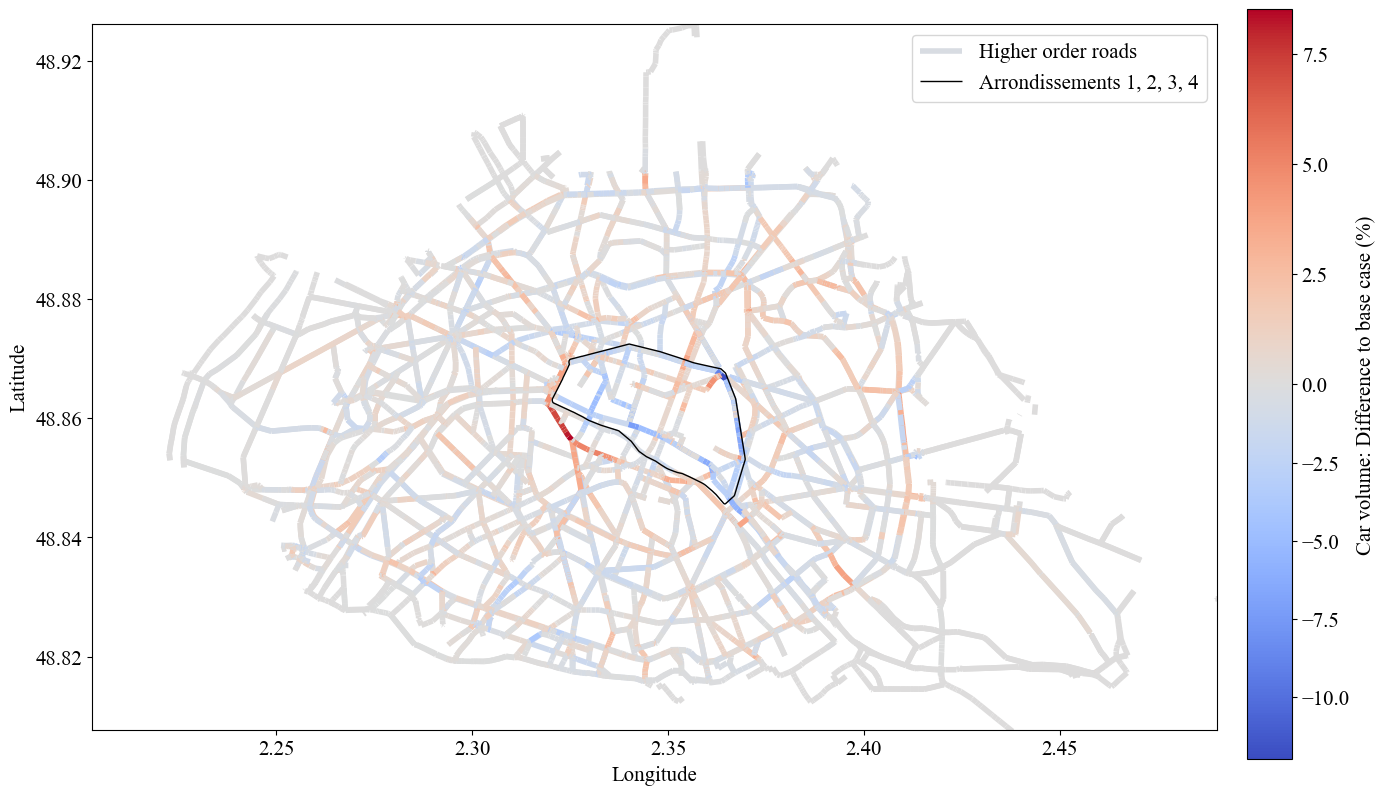

In [ ]:
pf.plot_simulation_output(gdf_basecase_difference, districts_of_interest=districts_of_interest, is_for_1pm = string_is_for_1pm, in_percentage = plot_in_percentage, districts=districts)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_11536/4277919684.py:94: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)


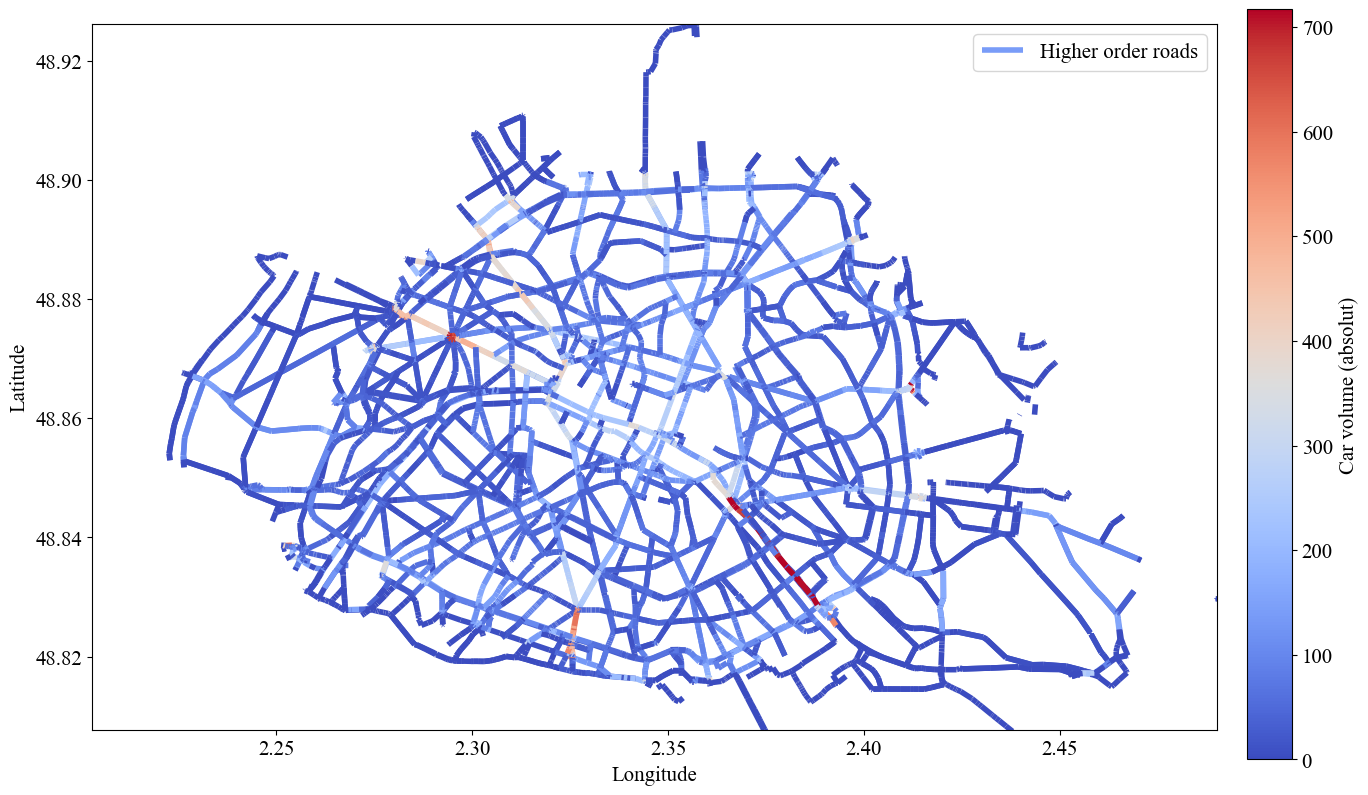

In [ ]:
# import glob
# import gzip
# import math
# import random
# import pickle

# import numpy as np
# import pandas as pd
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
# from matplotlib.colors import LogNorm
# import shapely.wkt as wkt
# from shapely.geometry import Point, LineString, box
# from shapely.ops import nearest_points
# import lxml.etree as ET
# import tqdm
# import wandb
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as T
# from torch.utils.data import DataLoader, Dataset, Subset
# import torch_geometric
# from torch_geometric.data import Data, Batch
# from torch_geometric.transforms import LineGraph
# import re
# from matplotlib.colors import TwoSlopeNorm

# from shapely.ops import unary_union
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

pf.plot_simulation_output_basecase(gdf_basecase_mean, districts_of_interest=districts_of_interest, is_for_1pm = string_is_for_1pm)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_11536/102510776.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)


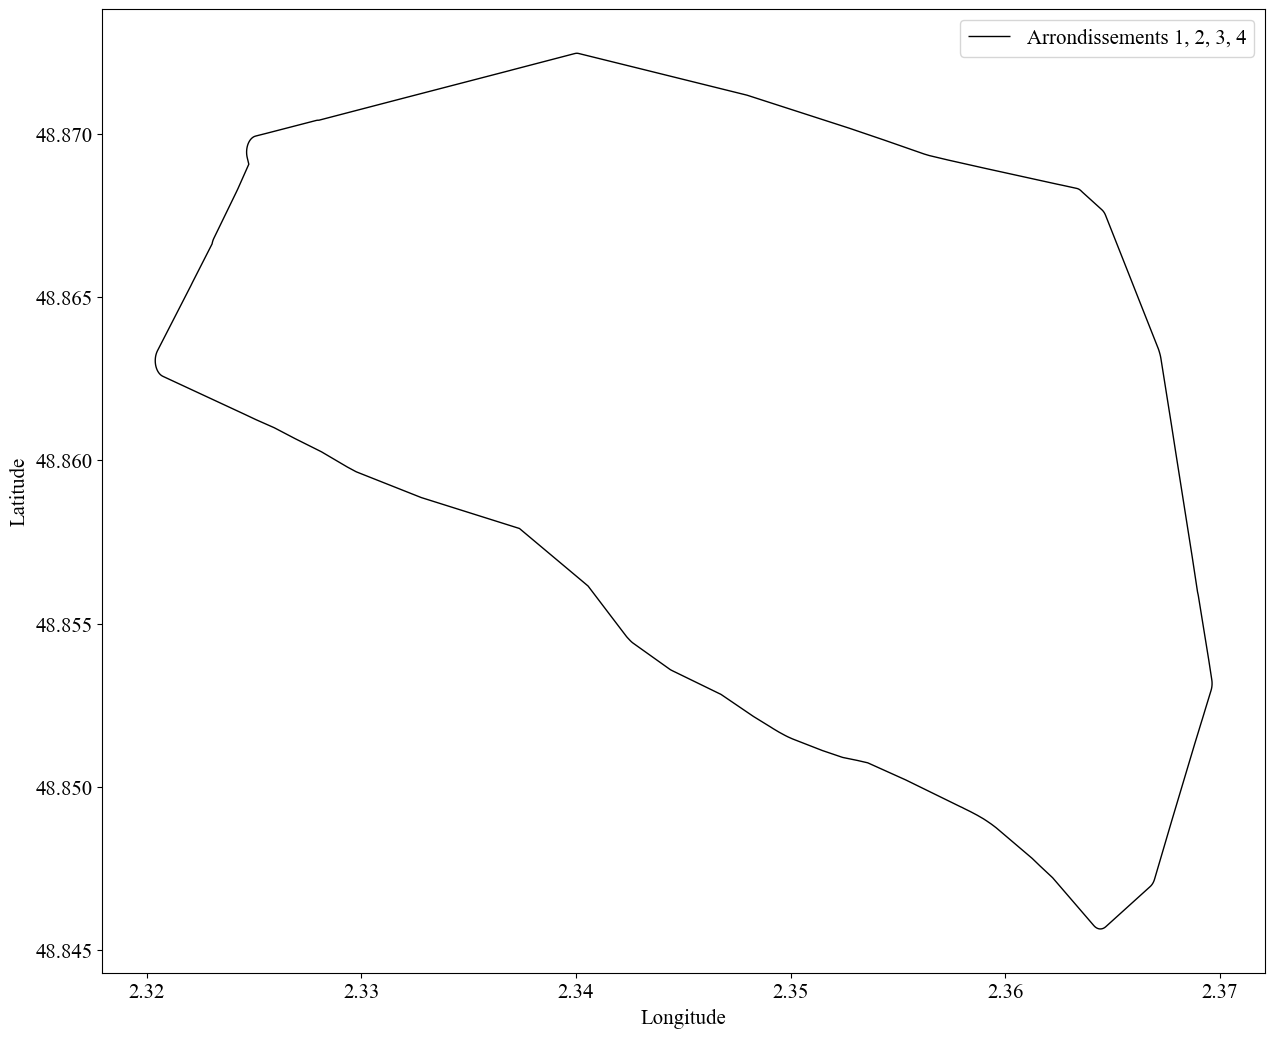

In [ ]:
def plot_just_zone(df, districts_of_interest: list, is_for_1pm: str):
    # Convert DataFrame to GeoDataFrame
    
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:2154")
    gdf = gdf.to_crs(epsg=4326)

    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
   
    
    target_districts = districts[districts['c_ar'].isin(districts_of_interest)]
    other_districts = districts[~districts['c_ar'].isin(districts_of_interest)]

    
    
    # Add buffer to target districts to avoid overlapping with edges
    buffered_target_districts = target_districts.copy()
    buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)
    # Ensure the buffered_target_districts GeoDataFrame is in the same CRS
    if buffered_target_districts.crs != gdf.crs:
        buffered_target_districts.to_crs(gdf.crs, inplace=True)

    # Create a single outer boundary
    outer_boundary = unary_union(buffered_target_districts.geometry).boundary

    # Plot only the outer boundary
    gpd.GeoSeries(outer_boundary, crs=gdf.crs).plot(ax=ax, edgecolor='black', linewidth=1, label="Arrondissements " + list_to_string(districts_of_interest), zorder=4)

    # ax.set_aspect('equal')
    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    
    # Customize the plot with Times New Roman font and size 15
    plt.xlabel("Longitude", fontname='Times New Roman', fontsize=15)
    plt.ylabel("Latitude", fontname='Times New Roman', fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
        label.set_fontsize(15)
    ax.legend(prop={'family': 'Times New Roman', 'size': 15})
    
    # Manually set the position of the main plot axis
    # ax.set_position([0.1, 0.1, 0.75, 0.75])

    # Create an axis on the right side for the color bar
    # cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar

    # Create the color bar
    # sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    # sm._A = []
    # cbar = plt.colorbar(sm, cax=cax)
    
    # # Set color bar font properties
    # cbar.ax.tick_params(labelsize=15)
    # for t in cbar.ax.get_yticklabels():
    #     t.set_fontname('Times New Roman')
    # cbar.ax.yaxis.label.set_fontname('Times New Roman')
    # cbar.ax.yaxis.label.set_size(15)
    # if in_percentage:
    #     cbar.set_label('Car volume: Difference to base case (%)', fontname='Times New Roman', fontsize=15)
    
    # cbar.set_label('Car volume (absolut)', fontname='Times New Roman', fontsize=15)
    plt.savefig("results/" + list_to_string(districts_of_interest, "_"), bbox_inches='tight')
    plt.show()
    
plot_just_zone(gdf_basecase_mean, districts_of_interest=districts_of_interest, is_for_1pm = string_is_for_1pm)